In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import requests,json
import sys
import pandas as pd
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO
from dateutil.relativedelta import relativedelta
import calendar
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
close_df=pd.read_csv('close_df.csv')
close_df

,Unnamed: 0,600094.XSHG,600160.XSHG,600008.XSHG,600903.XSHG,000959.XSHE,600970.XSHG,002302.XSHE,600823.XSHG,002503.XSHE,600664.XSHG
0,2015-01-05,7.82,4.69,5.11,NaN,4.30,7.96,7.45,4.46,3.44,5.27
1,2015-01-06,7.74,4.89,5.62,NaN,4.24,7.72,7.30,4.27,3.39,5.27
2,2015-01-07,8.51,4.92,5.39,NaN,4.26,7.65,7.29,4.28,3.51,5.27
3,2015-01-08,8.77,4.89,5.34,NaN,4.18,7.34,7.09,4.08,3.86,5.27
4,2015-01-09,8.70,4.87,5.17,NaN,4.15,7.26,7.01,4.10,3.74,5.27
...,...,...,...,...,...,...,...,...,...,...,...
1421,2020-11-05,5.23,6.87,3.02,11.41,3.85,6.78,9.43,6.07,2.31,3.34
1422,2020-11-06,5.19,6.88,3.02,11.60,3.86,6.74,9.43,6.01,2.29,3.32
1423,2020-11-09,5.16,6.85,3.03,11.55,3.92,6.72,9.55,6.00,2.38,3.34
1424,2020-11-10,5.07,7.03,3.03,11.85,3.89,6.90,9.48,6.18,2.36,3.30


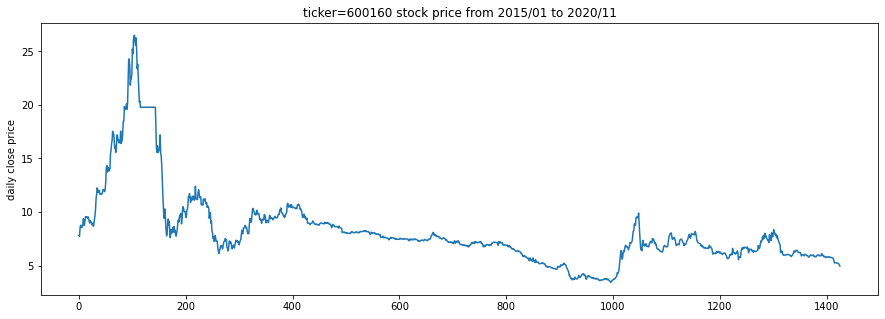

In [3]:
# visualize daily close data, lable y = column 1, ticker = 600094
close_df['600094.XSHG'].plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=600160 stock price from 2015/01 to 2020/11')
plt.show()

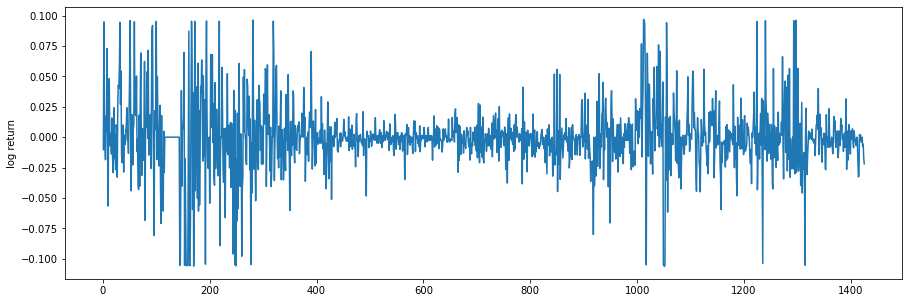

In [4]:
#log return
log_diff = (np.log(close_df['600094.XSHG']) - np.log(close_df['600094.XSHG'].shift(1))).dropna()
log_diff.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

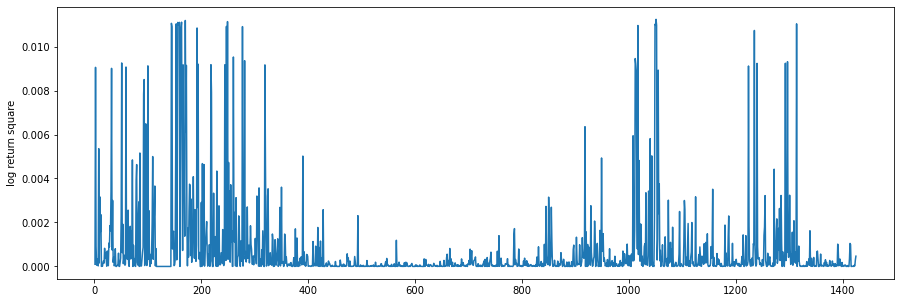

In [5]:

#log return square 
log_rtn_square = ((log_diff-log_diff.mean())*(log_diff-log_diff.mean())).dropna()
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [6]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.951160e+00
p-value                        3.123300e-12
#Lags Used                     1.600000e+01
Number of Observations Used    1.408000e+03
Critical Value (1%)           -3.435003e+00
Critical Value (5%)           -2.863595e+00
Critical Value (10%)          -2.567864e+00
dtype: float64


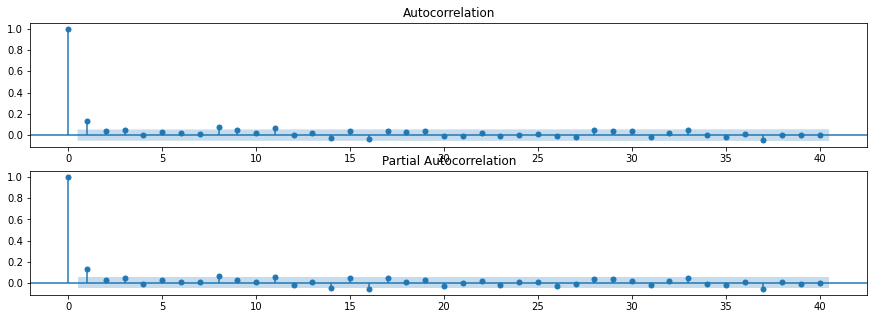

In [7]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_diff, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_diff, lags=40, ax=ax2)

In [8]:
print(log_diff.describe())

count    1425.000000
mean       -0.000319
std         0.027718
min        -0.106330
25%        -0.010794
50%         0.000000
75%         0.008310
max         0.096918
Name: 600094.XSHG, dtype: float64


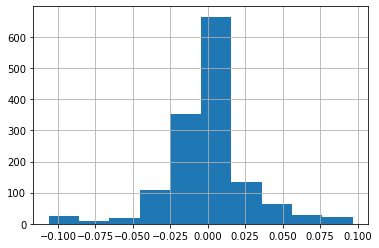

In [9]:
log_diff.hist()
plt.show()

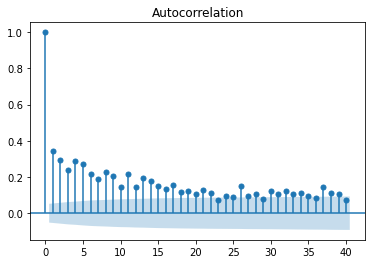

In [10]:
#acf for log return sqaure
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(log_rtn_square, lags=40)
pyplot.show()

In [11]:
# build garch(1,1) model for log return, by using constant mean, normal dist.
from arch.univariate import arch_model
model = arch_model(log_diff, mean='constant')
res = model.fit(update_freq=0)
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3439.3181792122205
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            600094.XSHG   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                3439.32
Distribution:                  Normal   AIC:                          -6870.64
Method:            Maximum Likelihood   BIC:                          -6849.59
                                        No. Observations:                 1425
Date:                Thu, Nov 12 2020   Df Residuals:                     1421
Time:                        22:44:17   Df Model:                            4
                                   Mean Model                                  


In [12]:
# given the result, maybe should consider I-GARCH model
pd.DataFrame(res.params)

,params
mu,-0.001059
omega,0.000015
alpha[1],0.100000
beta[1],0.880000


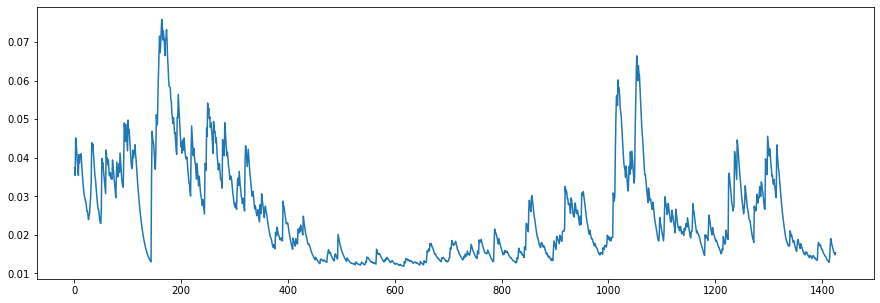

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,5))
res.conditional_volatility.dropna().plot() 
plt.show()

In [14]:
forecasts = res.forecast(horizon=1)
print(forecasts.mean.dropna().head())
print(forecasts.residual_variance.dropna().head())
print(forecasts.variance.dropna().head())

           h.1
1425 -0.001059
           h.1
1425  0.000267
           h.1
1425  0.000267


In [25]:
########EGARCH 600160.XSHG
egarch = arch_model(log_diff, mean='AR', lags=1, vol='EGARCH', p=1, o=1, q=1, rescale=False)
result = egarch.fit(update_freq=0, disp=False)
print(result.summary())

                          AR - EGARCH Model Results                           
Dep. Variable:            600094.XSHG   R-squared:                       0.008
Mean Model:                        AR   Adj. R-squared:                  0.007
Vol Model:                     EGARCH   Log-Likelihood:                3450.89
Distribution:                  Normal   AIC:                          -6889.78
Method:            Maximum Likelihood   BIC:                          -6858.22
                                        No. Observations:                 1424
Date:                Fri, Nov 13 2020   Df Residuals:                     1418
Time:                        16:24:01   Df Model:                            6
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const         -1.3649e-03  4.465e-02 -3.057

In [26]:
forecasts = result.forecast(horizon=1)
print(forecasts.mean.dropna().head())
print(forecasts.residual_variance.dropna().head())
print(forecasts.variance.dropna().head())

           h.1
1425 -0.002374
           h.1
1425  0.000174
           h.1
1425  0.000174


In [27]:
##########TGARCH 600094.XSHG
tgarch = arch_model(log_diff, vol='GARCH', p=1, o=1, q=1, power=2, dist='ged', rescale=False)
result = egarch.fit(update_freq=0, disp=False)
print(result.summary())

                          AR - EGARCH Model Results                           
Dep. Variable:            600094.XSHG   R-squared:                       0.008
Mean Model:                        AR   Adj. R-squared:                  0.007
Vol Model:                     EGARCH   Log-Likelihood:                3450.89
Distribution:                  Normal   AIC:                          -6889.78
Method:            Maximum Likelihood   BIC:                          -6858.22
                                        No. Observations:                 1424
Date:                Fri, Nov 13 2020   Df Residuals:                     1418
Time:                        16:24:11   Df Model:                            6
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const         -1.3649e-03  4.465e-02 -3.057

In [28]:
forecasts = result.forecast(horizon=1)
print(forecasts.mean.dropna().head())
print(forecasts.residual_variance.dropna().head())
print(forecasts.variance.dropna().head())

           h.1
1425 -0.002374
           h.1
1425  0.000174
           h.1
1425  0.000174
